# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto

Import packages

In [149]:

import pandas as pd; # type: ignore
import numpy as np; # type: ignore
from sklearn.preprocessing import OneHotEncoder; # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os;
from kaggle.api.kaggle_api_extended import KaggleApi; # type: ignore

Download data using Kaggle KPI

In [150]:
# Specify the dataset and the path to save it
dataset_name = 'tunguz/used-car-auction-prices'  # Replace with your actual Kaggle dataset name
download_path = './kaggle_datasets'     # Folder to store the dataset

# Create download path if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Check if file exists
dataset_file_path = os.path.join(download_path, 'car_prices.csv')   
# Check if the dataset already exists in the folder
if not os.path.exists(dataset_file_path):
    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()  # Authenticate using your Kaggle credentials

    # Download the dataset
    print(f"Downloading {dataset_name}...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

    print("Download complete.")
else:
    print("Dataset already exists, download skipped.")

# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')
df.head()

Dataset already exists, download skipped.


/var/folders/mv/9l39xh61679g3fk2_5cyrrzh0000gn/T/ipykernel_49361/1299253034.py:30: DtypeWarning: Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,Unnamed: 16
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),NaN
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),NaN
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),NaN
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),NaN
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),NaN


In [151]:
# Load datasets
msrp = pd.read_csv('MSRP.csv')

# Standardize column names and values
msrp.rename(columns={
    'Make': 'make',
    "Model": "model",
    "Year": "year",
    "Transmission Type": "transmission"
}, inplace=True)

msrp['transmission'] = msrp['transmission'].str.lower()

# Create matching keys
df['match_key'] = (
    df['year'].astype(str).str.lower() + '_' + 
    df['make'].str.lower() + '_' + 
    df['model'].str.lower() + '_' + 
    df['transmission'].str.lower()
)

msrp['match_key'] = (
    msrp['year'].astype(str).str.lower() + '_' + 
    msrp['make'].str.lower() + '_' + 
    msrp['model'].str.lower() + '_' + 
    msrp['transmission'].str.lower()
)

# Sort by MSRP (ascending) and keep first (min) for each match_key
msrp_min_row = msrp.sort_values('MSRP').drop_duplicates('match_key', keep='first')

# Merge with original car data (keeping all car rows but adding MSRP where matched)
car_with_msrp = df.merge(
    msrp_min_row[['match_key', 'MSRP']],  # Only keep needed columns
    on='match_key',
    how='left'
)

# Drop the temporary key column
car_with_msrp = car_with_msrp.drop(columns=['match_key'])

# Save the merged DataFrame to a new CSV file
car_with_msrp.to_csv('car_prices_with_msrp.csv', index=False)

# Data Cleaning
__Done__
1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)
3) Simplify ['body'] (collapse all 85 body types to 9 types)
4) Convert ['saledate']
5) Age of car (from ['saledate'])


In [152]:
# now we can use the car_prices_with_msrp DataFrame
df = pd.read_csv('car_prices_with_msrp.csv')

/var/folders/mv/9l39xh61679g3fk2_5cyrrzh0000gn/T/ipykernel_49361/484334820.py:2: DtypeWarning: Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('car_prices_with_msrp.csv')


In [153]:
print("Start: ", df.shape)
# Remove 'Unamed: 16' column
df.drop('Unnamed: 16', axis=1, inplace=True)

# 1 - Remove rows that have missing values
# check count first
non_null_rows = df.notna().all(axis=1).sum()
print(f"Number of rows with no NaN: {non_null_rows}")
print(df.columns.unique())
# drop rows with NaN values
df.dropna(inplace=True)

Start:  (558837, 18)
Number of rows with no NaN: 54481
Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate', 'MSRP'],
      dtype='object')


In [154]:
print("After removing missing values: ", len(df))

# 2 - One-hot encode the 'transmission' column
print(df['transmission'].unique())
df['auto_transmission'] = np.where(df['transmission'].str.contains('automatic', case=False), 1, 0)

# 3 - One-hot encode the 'body' column (count 85 unique values --> reduce to 8)
# ['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan' 'van']
print('unique values in body:')
print(df['body'].unique())
df['body_type'] = np.nan
df['body_type'] = np.where(df['body'].str.contains('minivan', case=False), 'minivan', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('sedan', case=False), 'sedan', df['body'])
df['body_type'] = np.where(df['body'].str.contains('wagon', case=False), 'wagon', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('coupe', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('koup', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('convertible', case=False), 'convertible', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('hatchback', case=False), 'hatchback', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains(r'\bvan\b', case=False), 'van', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('truck', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('cab', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('crew', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('suv', case=False), 'suv', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('Minivan', case=False), 'minivan', df['body_type'])
print('remaining unique values in body_type:')
print(df['body_type'].unique())

# 4 - Converting 'saledate' to datetime (solution provided by ChatGPT)
# Handle invalid or unexpected values in the 'saledate' column
# Extract just the date part (e.g., "Dec 16 2014") before conversion
df['saledate'] = pd.to_datetime(
    df['saledate'].str.extract(r'(\w{3} \d{2} \d{4})')[0], 
    format='%b %d %Y', 
    errors='coerce'
)
# 5 - Ensure 'saledate' is in datetime format and create a new column 'car_age'
df['car_age'] = np.where(
    df['saledate'].notna(),
    df['saledate'].dt.year - df['year'],
    np.nan
)

# Drop old columns
df.drop('transmission', axis=1, inplace=True)
df.drop('body', axis=1, inplace=True)
print("Finish: ", df.shape)


After removing missing values:  54481
['automatic' 'manual']
unique values in body:
['SUV' 'Sedan' 'Wagon' 'Hatchback' 'G Coupe' 'G Sedan' 'Elantra Coupe'
 'Coupe' 'CTS Coupe' 'E-Series Van' 'Van' 'Extended Cab' 'G Convertible'
 'Minivan' 'G37 Convertible' 'Convertible' 'Crew Cab' 'Quad Cab'
 'Regular Cab' 'Double Cab' 'Genesis Coupe' 'Q60 Convertible' 'SuperCab'
 'G37 Coupe' 'Cab Plus 4' 'Q60 Coupe' 'TSX Sport Wagon' 'CTS Wagon'
 'CTS-V Coupe' 'Beetle Convertible' 'CTS-V Wagon' 'Ram Van' 'sedan'
 'Cab Plus' 'van' 'King Cab' 'Access Cab' 'g sedan' 'g coupe' 'suv'
 'g convertible' 'e-series van' 'wagon' 'g37 convertible' 'minivan'
 'hatchback' 'convertible' 'crew cab' 'quad cab' 'cts coupe' 'coupe'
 'regular cab' 'elantra coupe' 'supercab' 'extended cab' 'q60 coupe'
 'king cab' 'double cab' 'access cab' 'genesis coupe' 'tsx sport wagon'
 'mega cab' 'q60 convertible' 'cab plus 4' 'SuperCrew']
remaining unique values in body_type:
['suv' 'sedan' 'wagon' 'hatchback' 'coupe' 'van' 'truck' '

In [155]:
print(df['body_type'].unique())

['suv' 'sedan' 'wagon' 'hatchback' 'coupe' 'van' 'truck' 'convertible'
 'minivan']


mapping body type by size of vehicle

In [156]:
size_mapping = {
    'convertible': 0,
    'coupe': 1,
    'hatchback': 2,
    'sedan': 3,
    'wagon': 4,
    'suv': 5,
    'minivan': 6,
    'truck': 7,
    'van': 8
}

df['body_size'] = df['body_type'].map(size_mapping)


# Data Vizualization
Plot 'mmr' v. 'sellingprice'

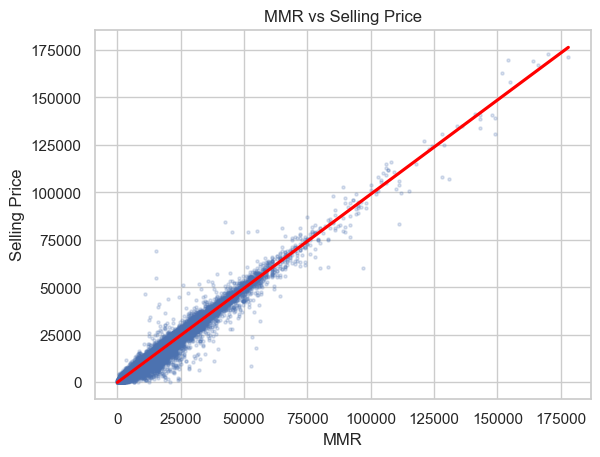

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
# ensure mmr and sellingprice are numeric
df['mmr'] = pd.to_numeric(df['mmr'], errors='coerce')
df['sellingprice'] = pd.to_numeric(df['sellingprice'], errors='coerce')
# Set the style of seaborn
sns.set(style="whitegrid")
plt.scatter(df['mmr'], df['sellingprice'], alpha=0.2, s=5) # Create a scatter plot
sns.regplot(x='mmr', y='sellingprice', data=df, scatter=False, color='red') # Linear fit line
plt.title('MMR vs Selling Price')
plt.xlabel('MMR')
plt.ylabel('Selling Price')
plt.show()

# Using features to predict selling price
List of numeric features:
1. year
2. condition
3. odometer
4. auto_transmission
5. car_age
6. MSRP

In [158]:
df_predictor = df[['year', 'condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP']]

In [159]:
X= df[['year', 'condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP']]
y = df['sellingprice']

Split into training and testing set

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=39)

Train the Linear Regression model

In [161]:
model = LinearRegression()

In [162]:
model.fit(X_train, Y_train)

LinearRegression()

Make predictions and evaluate the model

In [163]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(Y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2}")

Mean Squared Error (MSE): 26277843.11089697
R^2 (coefficient of determination): 0.7758815383008505


Plot predictions vs actual selling

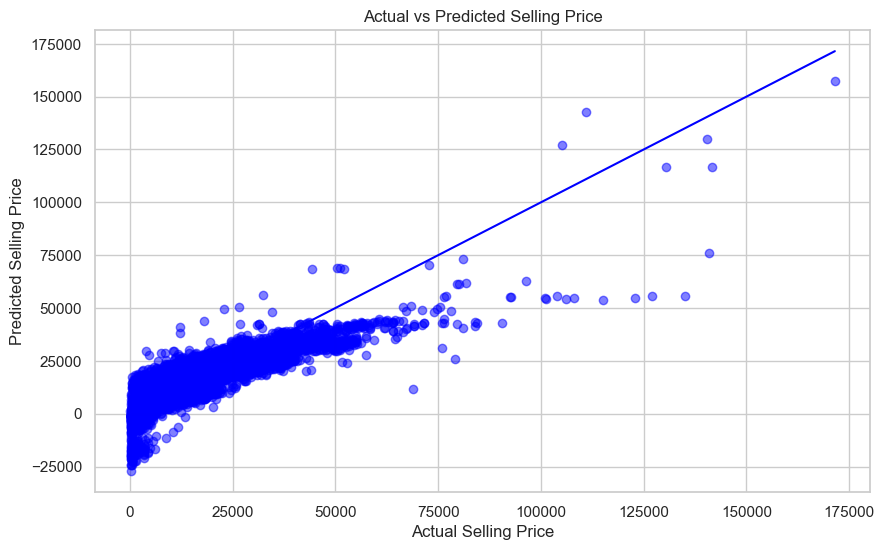

In [164]:
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred, alpha=0.5, color='blue') 
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='blue', linewidth=1.5)
plt.xlabel('Actual Selling Price') 
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.show()